In [0]:
from IPython.display import clear_output
clear_output()

In [22]:
!wget https://raw.githubusercontent.com/daniarnaizg/TFG-Amazon-Scraper/master/outputs/first500final.json

--2019-03-27 10:42:33--  https://raw.githubusercontent.com/daniarnaizg/TFG-Amazon-Scraper/master/outputs/first500final.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 74720 (73K) [text/plain]
Saving to: ‘first500final.json’

first500final.json  100%[===================>]  72.97K  --.-KB/s    in 0.02s   

2019-03-27 10:42:33 (2.93 MB/s) - ‘first500final.json’ saved [74720/74720]



In [0]:
!pip install --upgrade numpy
!pip install --upgrade pandas
clear_output()

In [2]:
"""
Tool to show progress
"""
!pip install -e git+https://github.com/tqdm/tqdm.git@master#egg=tqdm
# clear_output()

Obtaining tqdm from git+https://github.com/tqdm/tqdm.git@master#egg=tqdm
  Updating ./src/tqdm clone (to revision master)
  Found existing installation: tqdm 4.31.1
    Can't uninstall 'tqdm'. No files were found to uninstall.
  Running setup.py develop for tqdm


In [0]:
!rm -r dataset

In [0]:
!mkdir dataset
!mkdir dataset/0
!mkdir dataset/1
!mkdir dataset/2
!mkdir dataset/3

In [0]:
import json, requests
from PIL import Image
from io import BytesIO
from tqdm import tqdm

"""
Function that downloads every image of the json file to a folder named after its class. Each image's name contains
the class it corresponds to.

0 -> Modelo
1 -> Diseño
2 -> Composicion
2 -> Otro

"""

def requestImg(image_name, url):
    r = requests.get(url)
    i = Image.open(BytesIO(r.content))
    
    if image_name[0] is 'M':
        i.save("dataset/0/" + image_name)
    elif image_name[0] is 'D':
        i.save("dataset/1/" + image_name)
    elif image_name[0] is 'C':
        i.save("dataset/2/" + image_name)
    elif image_name[0] is 'O':
        i.save("dataset/3/" + image_name)
    
def downloadImgs():
    with open('first500final.json', 'r') as f:
        data = json.load(f)
        
    for i in tqdm(range(len(data))):
        url = data[str(i)]['URL']
        label = data[str(i)]['LABEL']
        image_name = label + '_' + str(i) + '.jpg'
        requestImg(image_name, url)

In [45]:
downloadImgs()

100%|██████████| 490/490 [02:01<00:00,  3.74it/s]


In [46]:
!ls dataset/3

Otro_141.jpg  Otro_201.jpg  Otro_347.jpg
Otro_173.jpg  Otro_308.jpg  Otro_375.jpg


---
> > KERAS
---

In [0]:
import matplotlib.pyplot as plt

import numpy as np
import glob
import cv2
import os

from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D
from keras.layers import Flatten, Lambda, BatchNormalization
from keras.models import Sequential
from keras.layers.advanced_activations import LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

In [0]:
'''Config of the model'''

EPOCHS = 10     # Number of training epochs
INIT_LR = 1e-3  # Initial Learning rate
BS = 32         # Batch size

data = []
labels = []

In [0]:
'''
Extraction of the data and label of every image.
'''
for folder in os.listdir('dataset/'):
  dir = 'dataset/' + folder + '/*.jpg'
  class_dir = glob.glob(dir)
  for imagePath in class_dir:
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (28, 28))
    image = img_to_array(image)
    data.append(image)
    labels.append(folder) # The label is the  folder each image is in

In [0]:
# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

In [0]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
	labels, test_size=0.25, random_state=42)

In [113]:
trainX.shape

(367, 28, 28, 3)

In [114]:
trainY.shape

(367,)

In [0]:
# convert the labels from integers to vectors
trainY = to_categorical(trainY, num_classes=4)
testY = to_categorical(testY, num_classes=4)

In [116]:
trainY.shape

(367, 4)

In [0]:
'''Initialization of the model'''
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

optimizer = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [0]:
model_path = 'test_amazon.h5'

In [0]:
# Load the model so it isn´t necessary to train it everytime
# model.load_weights(model_path)

In [120]:
'''Train the network'''
model.fit(trainX, trainY, batch_size=BS, validation_data=(testX, testY), epochs=EPOCHS, verbose=1)
model.save(model_path)

score = model.evaluate(testX, testY, verbose=1)

print('Test loss: ' + str(score[0]))
print('Test accuracy: ' + str(score[1]))

Train on 367 samples, validate on 123 samples
Epoch 1/10
367/367 [==============================] - 1s 4ms/step - loss: 0.5549 - acc: 0.7657 - val_loss: 0.3355 - val_acc: 0.8923
Epoch 2/10
367/367 [==============================] - 1s 3ms/step - loss: 0.3077 - acc: 0.8678 - val_loss: 0.2579 - val_acc: 0.9309
Epoch 3/10
367/367 [==============================] - 1s 3ms/step - loss: 0.2044 - acc: 0.9169 - val_loss: 0.2079 - val_acc: 0.9350
Epoch 4/10
367/367 [==============================] - 1s 3ms/step - loss: 0.1588 - acc: 0.9407 - val_loss: 0.1750 - val_acc: 0.9512
Epoch 5/10
367/367 [==============================] - 1s 3ms/step - loss: 0.1198 - acc: 0.9510 - val_loss: 0.1597 - val_acc: 0.9431
Epoch 6/10
367/367 [==============================] - 1s 3ms/step - loss: 0.1022 - acc: 0.9639 - val_loss: 0.1520 - val_acc: 0.9512
Epoch 7/10
367/367 [==============================] - 1s 3ms/step - loss: 0.0797 - acc: 0.9734 - val_loss: 0.1465 - val_acc: 0.9512
Epoch 8/10
367/367 [==========

In [153]:
!ls

dataset  first500final.json  sample_data  src  test_amazon.h5


---
> EVALUACION
---


>* 0 — MODELO
* 1 — DISEÑO
* 2 — COMPOSICION
* 3 — OTRO



In [0]:

# EVALUACION

# load the image
image = cv2.imread('dataset/2/Composición_97.jpg')
orig = image.copy()

# pre-process the image for classification
image = cv2.resize(image, (28, 28))
image = image.astype("float") / 255.0
image = img_to_array(image)
image = np.expand_dims(image, axis=0)

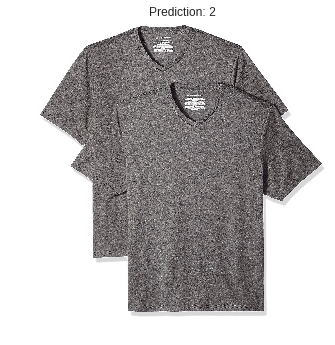

In [152]:
predictions = model.predict(image)[0]
prediction = predictions.argmax()

plt.title("Prediction: " + str(prediction))
plt.imshow(orig)
plt.axis('off')
plt.show()

In [140]:
!ls dataset/2

Composición_0.jpg    Composición_222.jpg  Composición_40.jpg
Composición_100.jpg  Composición_231.jpg  Composición_410.jpg
Composición_105.jpg  Composición_237.jpg  Composición_419.jpg
Composición_107.jpg  Composición_245.jpg  Composición_41.jpg
Composición_10.jpg   Composición_24.jpg   Composición_422.jpg
Composición_118.jpg  Composición_252.jpg  Composición_43.jpg
Composición_11.jpg   Composición_262.jpg  Composición_448.jpg
Composición_124.jpg  Composición_264.jpg  Composición_46.jpg
Composición_127.jpg  Composición_270.jpg  Composición_481.jpg
Composición_13.jpg   Composición_286.jpg  Composición_48.jpg
Composición_143.jpg  Composición_28.jpg   Composición_4.jpg
Composición_145.jpg  Composición_292.jpg  Composición_50.jpg
Composición_147.jpg  Composición_298.jpg  Composición_52.jpg
Composición_148.jpg  Composición_29.jpg   Composición_57.jpg
Composición_149.jpg  Composición_2.jpg	  Composición_59.jpg
Composición_14.jpg   Composición_310.jpg  Composición_5.jpg
Composición_152.jpg  C